In [7]:
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration

model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf").cuda()
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")


Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.79s/it]
Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


In [44]:
prompt = "USER: <image>\nWhat's the content of the image? ASSISTANT:"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw).resize((336, 336))

inputs = processor(images=image, text=prompt, return_tensors="pt")
inputs = {k: v.cuda() for k, v in inputs.items()}

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=30)
processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

"USER:  \nWhat's the content of the image? ASSISTANT: The image features a street scene with a stop sign, a car, and a red building. There are also two lions in the scene, one"

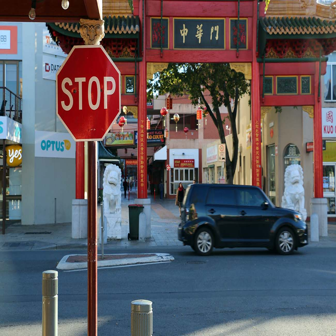

In [39]:
image

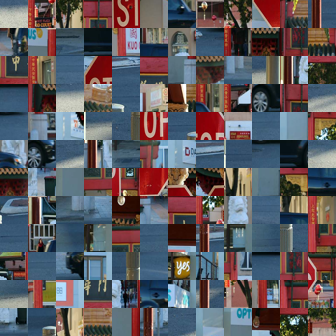

In [57]:
shuffled_image = shuffle_image_patches(image, 28)
display(shuffled_image)

In [58]:
prompt = "USER: <image>\nWhat's the content of the image? ASSISTANT:"

inputs = processor(images=shuffled_image, text=prompt, return_tensors="pt")
inputs = {k: v.cuda() for k, v in inputs.items()}

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=30)
processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

"USER:  \nWhat's the content of the image? ASSISTANT: The image is a collage of various street signs, buildings, and vehicles, showcasing a busy city street."

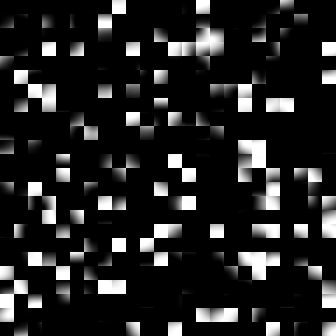

Label: 5, Prediction: 0


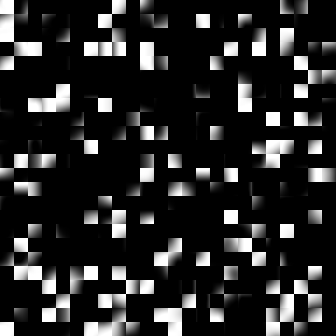

Label: 0, Prediction: 0


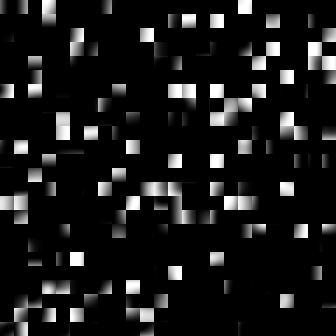

Label: 4, Prediction: 0


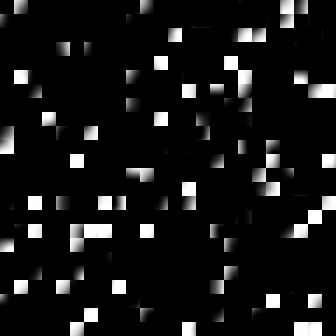

Label: 1, Prediction: 0


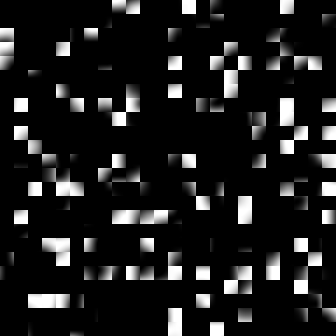

Label: 9, Prediction: 0


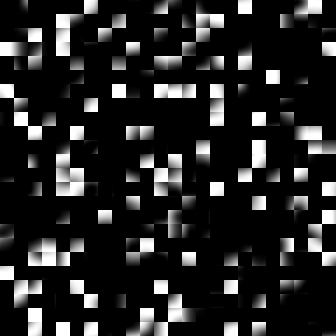

Label: 2, Prediction: 0


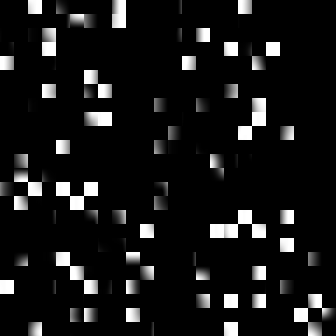

Label: 1, Prediction: 0


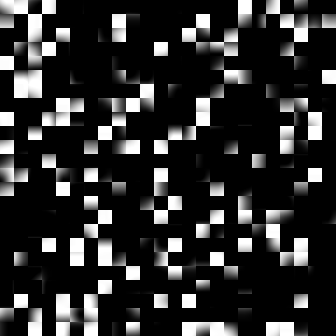

Label: 3, Prediction: 0


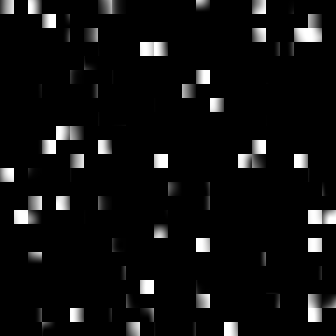

Label: 1, Prediction: 0


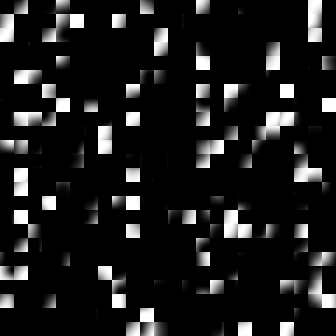

Label: 4, Prediction: 0


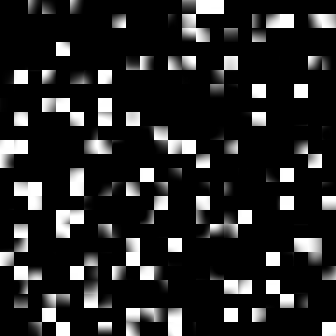

Label: 3, Prediction: 0


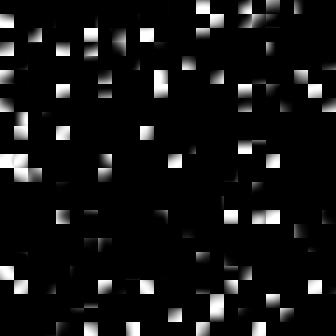

Label: 5, Prediction: 0


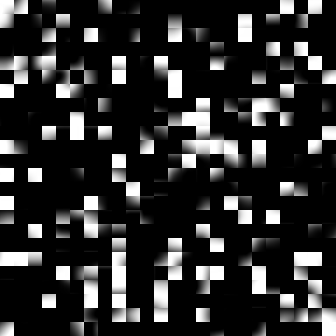

Label: 3, Prediction: 0


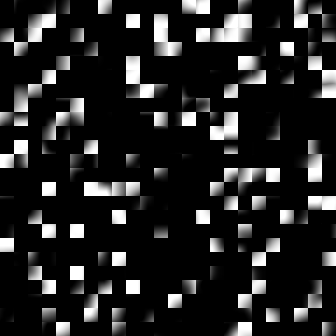

Label: 6, Prediction: 0


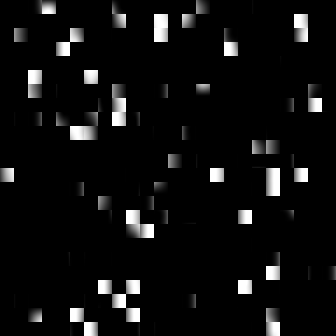

Label: 1, Prediction: 0


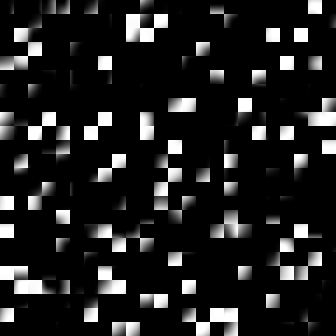

Label: 7, Prediction: 0


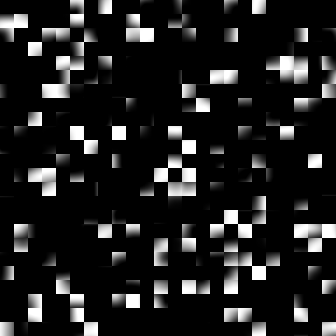

Label: 2, Prediction: 0


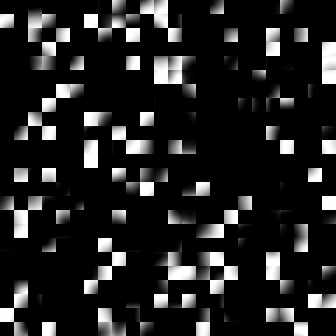

Label: 8, Prediction: 0


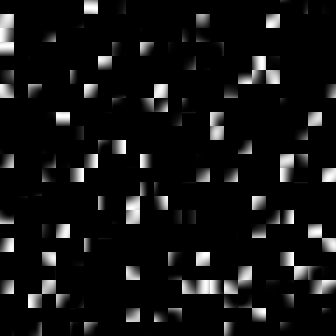

Label: 6, Prediction: 0


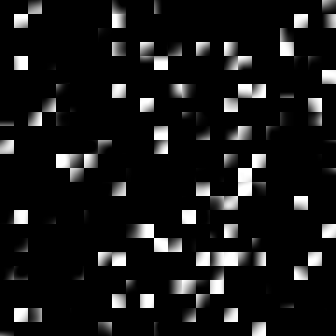

Label: 9, Prediction: 0
Accuracy: 0.05


In [75]:
from torchvision import datasets

# 加载 MNIST 数据集为 PIL.Image 格式
mnist_train = datasets.MNIST(
    root='./data',  # 数据存放路径
    train=True,     # 加载训练集
    transform=None,  # 不进行任何变换，保留为原始 PIL.Image 格式
    download=True    # 如果数据集不存在则下载
)

mnist_test = datasets.MNIST(
    root='./data',
    train=False,  # 加载测试集
    transform=None  # 不进行任何变换
)

accs = [] 
# 查看前几个样本
for i in range(20):
    image, label = mnist_train[i]  # 获取一个样本（image 为 PIL.Image，label 为数字标签）
    image = image.resize((336, 336))
    # print(f"Label: {label}")
    # display(image.resize((336, 336)))

    prompt = "USER: <image>\nWhat's the digit? Answer with a single number. ASSISTANT:"

    image = shuffle_image_patches(image, 14)
    display(image)
    inputs = processor(images=image, text=prompt, return_tensors="pt")
    inputs = {k: v.cuda() for k, v in inputs.items()}

    # Generate
    generate_ids = model.generate(**inputs, max_new_tokens=30)
    output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    prediction = output.split("ASSISTANT:")[1].strip()
    print(f"Label: {label}, Prediction: {prediction}")
    accs.append(str(label) == prediction)

print(f"Accuracy: {sum(accs) / len(accs)}")

In [ ]:
Accuracy: 0.85

In [13]:
from PIL import Image
import random

def shuffle_image_patches(image: Image.Image, patch_size: int) -> Image.Image:
    """
    Splits an image into patches of size patch_size x patch_size, shuffles them randomly,
    and returns the shuffled image.
    
    Args:
        image (Image.Image): The input image (PIL format).
        patch_size (int): The size of each square patch.
        
    Returns:
        Image.Image: The shuffled image (PIL format).
    """
    # Ensure the image dimensions are divisible by the patch size
    width, height = image.size
    assert width % patch_size == 0 and height % patch_size == 0, \
        "Image dimensions must be divisible by patch size."
    
    # Calculate the number of patches in each dimension
    num_patches_x = width // patch_size
    num_patches_y = height // patch_size
    
    # Extract patches
    patches = []
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            patch = image.crop((x, y, x + patch_size, y + patch_size))
            patches.append(patch)
    
    # Shuffle patches
    random.shuffle(patches)
    
    # Create a new blank image to paste shuffled patches
    shuffled_image = Image.new('RGB', (width, height))
    
    # Paste shuffled patches back into the image
    for idx, patch in enumerate(patches):
        x = (idx % num_patches_x) * patch_size
        y = (idx // num_patches_x) * patch_size
        shuffled_image.paste(patch, (x, y))
    
    return shuffled_image

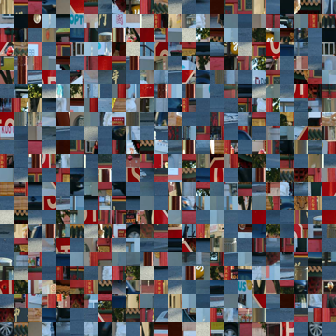

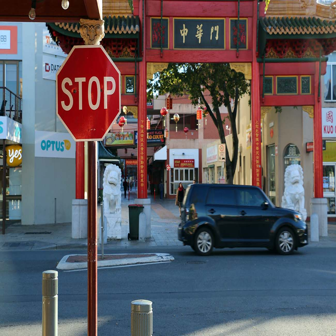

In [12]:
image